<a href="https://colab.research.google.com/github/ChenHY1217/Projects-In-MLAI-LABS/blob/main/LAB1/PIMLAI_Lab1_week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
np.random.seed(42)

# load dataset
df = pd.read_csv(path + "/creditcard.csv")

Using Colab cache for faster access to the 'creditcardfraud' dataset.


### Data Quality Audit

--- Missingness Summary ---
No missing values found.

--- Target Distribution (Class) ---
Class
0    284315
1       492
Name: count, dtype: int64


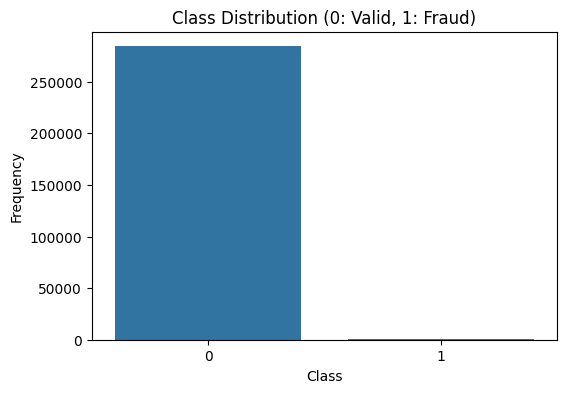


--- Bias / Class Imbalance ---
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

Fraud transactions account for only 0.1727% of the dataset.


In [ ]:
# 1. Missingness Summary
print("--- Missingness Summary ---")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found.")

# 2. Target Distribution (Class)
print("\n--- Target Distribution (Class) ---")
class_counts = df['Class'].value_counts()
print(class_counts)

# 3. Visualize Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Valid, 1: Fraud)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# 4. Bias/Imbalance Analysis
print("\n--- Bias / Class Imbalance ---")
class_percentages = df['Class'].value_counts(normalize=True) * 100
print(class_percentages)
print(f"\nFraud transactions account for only {class_percentages[1]:.4f}% of the dataset.")

In [ ]:
# Check for exact duplicates

exact_duplicates_count = df.duplicated().sum()
print(f"Number of exact duplicate rows: {exact_duplicates_count}")

# Check for near duplicates (Numerical columns withing 4 decimal points)

# First extracting numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'Class' in numerical_cols:
    numerical_cols.remove('Class')

# Create a temporary DataFrame with rounded numerical columns
df_rounded = df[numerical_cols].round(4)

# Check for duplicates in the rounded DataFrame
near_duplicates_count = df_rounded.duplicated().sum()

print(f"\nNumber of near duplicate rows (after rounding numerical columns to 4 decimal places): {near_duplicates_count}")

Number of exact duplicate rows: 1081

Number of near duplicate rows (after rounding numerical columns to 4 decimal places): 1081


In [ ]:
# Drop the 'Time' column as per Leakage Notes
df.drop('Time', axis=1, inplace=True)

df.drop_duplicates(inplace=True)


# Check duplicates were removed
exact_duplicates_count = df.duplicated().sum()
print(f"Number of exact duplicate rows: {exact_duplicates_count}")

# Re-extract numerical columns after dropping 'Time'
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'Class' in numerical_cols:
    numerical_cols.remove('Class')

# Check all near duplicates were removed
df_rounded = df[numerical_cols].round(4)
near_duplicates_count = df_rounded.duplicated().sum()

print(f"\nNumber of near duplicate rows (after rounding numerical columns to 4 decimal places): {near_duplicates_count}")

Number of exact duplicate rows: 0

Number of near duplicate rows (after rounding numerical columns to 4 decimal places): 0


In [ ]:
# Separate features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Perform 80/20 train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

print("\nDistribution of 'Class' in original DataFrame:")
print(y.value_counts(normalize=True))

print("\nDistribution of 'Class' in y_train:")
print(y_train.value_counts(normalize=True))

print("\nDistribution of 'Class' in y_test:")
print(y_test.value_counts(normalize=True))

Shape of X_train: (220530, 29)
Shape of X_test: (55133, 29)
Shape of y_train: (220530,)
Shape of y_test: (55133,)

Distribution of 'Class' in original DataFrame:
Class
0    0.998284
1    0.001716
Name: proportion, dtype: float64

Distribution of 'Class' in y_train:
Class
0    0.998286
1    0.001714
Name: proportion, dtype: float64

Distribution of 'Class' in y_test:
Class
0    0.998277
1    0.001723
Name: proportion, dtype: float64


### Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Identify columns to scale
# 'Amount' requires scaling. 'V1'-'V28' are PCA components, so we keep them as is.
features_to_scale = ['Amount']

# 2. Create the ColumnTransformer
# This applies StandardScaler to 'Amount' and passes other columns through.
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), features_to_scale)
    ],
    remainder='passthrough'  # Keep V1-V28 as they are
)

# 3. Create the Pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# 4. Fit the pipeline on Training data ONLY
preprocessing_pipeline.fit(X_train)

# 5. Transform Training and Test data
X_train_scaled = preprocessing_pipeline.transform(X_train)
X_test_scaled = preprocessing_pipeline.transform(X_test)

# 6. Reconstruct DataFrames (preserves column names and indices)
# Note: ColumnTransformer places transformed columns (Amount) first.
processed_columns = features_to_scale + [col for col in X_train.columns if col not in features_to_scale]

X_train_processed = pd.DataFrame(X_train_scaled, columns=processed_columns, index=X_train.index)
X_test_processed = pd.DataFrame(X_test_scaled, columns=processed_columns, index=X_test.index)

print("Preprocessing complete.")
display(X_train_processed.head())

Preprocessing complete.


,Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
85263,-0.256366,-0.204719,0.230561,0.585213,-1.042216,0.523612,-0.813961,0.521473,-0.349696,-1.985971,...,1.763844,0.428518,0.295196,0.769031,-0.295086,-0.358231,0.191942,-0.015486,0.104205,0.127050
87877,-0.340462,-1.536222,1.076634,1.158729,-1.014278,0.303728,-1.434520,0.880383,0.199717,-0.694732,...,-1.587533,-0.427334,0.020621,-0.183758,-0.104223,0.380524,0.767783,0.125901,-0.293290,-0.056513
199987,-0.270862,0.180614,1.100063,-1.022411,0.003125,0.208371,-1.445858,0.602641,0.118823,-0.112330,...,-0.255332,-0.240878,0.331292,0.920748,-0.059538,-0.033873,-0.277221,-0.151729,-0.074708,-0.046507
92683,-0.346073,-0.090912,0.770375,1.106896,0.000738,0.843993,0.130005,0.816123,-0.311543,-0.209850,...,1.355919,0.131621,-0.287096,-0.616660,-0.176805,-0.910379,-0.722550,0.077614,-0.335306,-0.300600
198830,-0.338786,-0.256459,1.085422,-0.698082,-1.339884,1.567292,-0.964274,1.967021,-1.024060,0.361965,...,0.131164,0.213442,0.092316,0.760264,-0.335504,0.795715,0.181275,-0.002008,-0.748489,-0.564823


KNN

Training kNN model
Predicting on Test set

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.88      0.75      0.81        95

    accuracy                           1.00     55133
   macro avg       0.94      0.87      0.90     55133
weighted avg       1.00      1.00      1.00     55133



<Figure size 600x500 with 0 Axes>

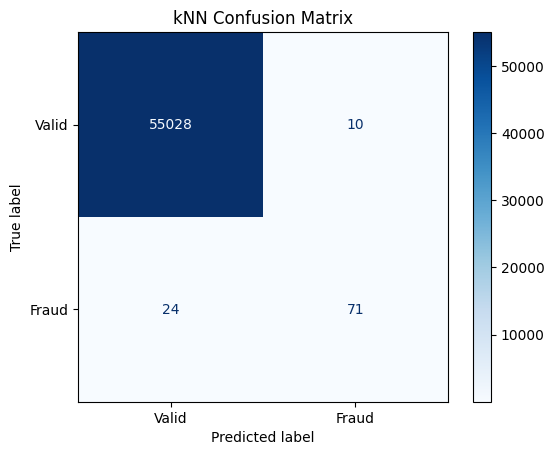

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize kNN model
# We use n_jobs=-1 to parallelize the computation as kNN can be slow on large datasets
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

print("Training kNN model")
knn.fit(X_train_processed, y_train)

print("Predicting on Test set")
y_pred = knn.predict(X_test_processed)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Valid', 'Fraud'])
disp.plot(cmap='Blues', values_format='d')
plt.title("kNN Confusion Matrix")
plt.grid(False)
plt.show()

## Week 2- **Experiment Log Below**

### Part C: SVM model with light Tuning

Now, we will train an SVM-family model and do light tuning, comparing the SVM to our week 1 baseline with the same split.

Training LinearSVC with light tuning...
Best C: {'C': 1}

--- Classification Report (LinearSVC) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.84      0.54      0.65        95

    accuracy                           1.00     55133
   macro avg       0.92      0.77      0.83     55133
weighted avg       1.00      1.00      1.00     55133



<Figure size 600x500 with 0 Axes>

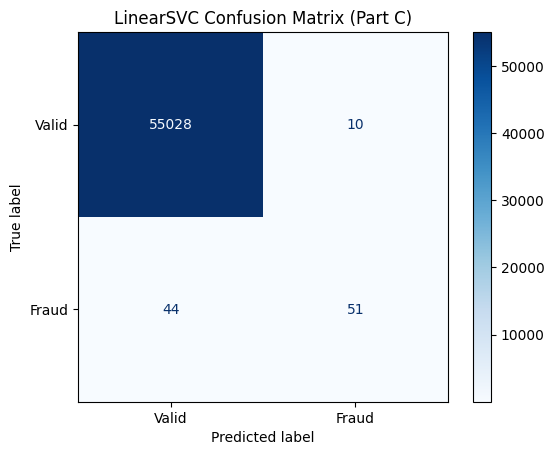

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize LinearSVC
svc_model = LinearSVC(
    dual=False,
    random_state=42,
    max_iter=5000
)


# Perform light tuning
param_grid = {
    "C": [0.1, 1, 10]
}

grid = GridSearchCV(
    svc_model,
    param_grid,
    cv=3,                 # 3-fold CV on training set only
    scoring="f1",         # MUST match Week 1 metric
    n_jobs=-1
)

print("Training LinearSVC with light tuning...")
grid.fit(X_train_processed, y_train)

best_svc = grid.best_estimator_
print("Best C:", grid.best_params_)

# Predict on test set
y_pred_svc = best_svc.predict(X_test_processed)

# Evaluate
print("\n--- Classification Report (LinearSVC) ---")
print(classification_report(y_test, y_pred_svc))

plt.figure(figsize=(6, 5))
cm_svc = confusion_matrix(y_test, y_pred_svc)
disp_svc = ConfusionMatrixDisplay(
    confusion_matrix=cm_svc,
    display_labels=["Valid", "Fraud"]
)
disp_svc.plot(cmap="Blues", values_format="d")
plt.title("LinearSVC Confusion Matrix (Part C)")
plt.grid(False)
plt.show()

The SVM performed poorly capturing the true Fraud instances. We try to split the datset more proportionately so that fraud instances are more represented.

In [ ]:
from sklearn.utils import resample

# Separate positive and negative samples from the processed training data
X_train_pos = X_train_processed[y_train == 1]
y_train_pos = y_train[y_train == 1]

X_train_neg = X_train_processed[y_train == 0]
y_train_neg = y_train[y_train == 0]

# Resample positive class (with replacement) to 1500 samples
X_train_pos_resampled, y_train_pos_resampled = resample(
    X_train_pos,
    y_train_pos,
    replace=True,     # Sample with replacement
    n_samples=1500,   # Target number of positive samples
    random_state=42   # For reproducibility
)

# Resample negative class (without replacement) to 492 samples
X_train_neg_resampled, y_train_neg_resampled = resample(
    X_train_neg,
    y_train_neg,
    replace=False,    # Sample without replacement
    n_samples=492,    # Target number of negative samples
    random_state=42   # For reproducibility
)

# Concatenate the resampled data to form the new balanced training set
# Reset index immediately after concatenation to ensure unique and aligned indices
small_x_train = pd.concat([X_train_pos_resampled, X_train_neg_resampled]).reset_index(drop=True)
small_y_train = pd.concat([y_train_pos_resampled, y_train_neg_resampled]).reset_index(drop=True)

# Shuffle the new dataset to mix positive and negative samples
# Now that indices are unique and aligned, this operation will correctly reorder both X and y.
shuffled_indices = small_x_train.sample(frac=1, random_state=42).index
small_x_train = small_x_train.loc[shuffled_indices]
small_y_train = small_y_train.loc[shuffled_indices]

print(f"Shape of small_x_train: {small_x_train.shape}")
print(f"Shape of small_y_train: {small_y_train.shape}")
print("\nDistribution of 'Class' in small_y_train:")
print(small_y_train.value_counts(normalize=True))
display(small_x_train.head())

Shape of small_x_train: (1992, 29)
Shape of small_y_train: (1992,)

Distribution of 'Class' in small_y_train:
Class
1    0.753012
0    0.246988
Name: proportion, dtype: float64


,Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
887,0.024214,-12.381048,8.213022,-16.962530,7.116091,-9.772826,-3.666836,-16.147363,2.078706,-4.250657,...,2.271082,0.537795,0.167703,1.503413,-0.767755,0.371951,-1.415639,-0.517022,-0.434621,0.292721
1671,-0.295335,2.327297,-1.085507,-1.259462,-1.564278,-0.969838,-1.277971,-0.639453,-0.501096,-1.788083,...,-0.419359,-0.359736,0.092452,0.832722,0.058884,0.041494,0.123391,0.068822,-0.001260,-0.058368
414,-0.324212,0.202402,1.176270,0.346379,2.882138,1.407133,-0.504355,1.438537,-0.395603,-1.555142,...,-1.762350,-0.206239,0.242560,0.841230,-0.370157,-0.026012,0.491954,0.234576,-0.279788,-0.331933
1080,6.698436,-3.499108,0.258555,-4.489558,4.853894,-6.974522,3.628382,5.431271,-1.946734,-0.775680,...,1.663394,-3.042626,-1.052368,0.204817,-2.119007,0.170279,-0.393844,0.296367,1.985913,-0.900452
1102,-0.324484,-8.762083,2.791030,-7.682767,6.991214,-5.230695,-0.357388,-9.685621,1.749335,-4.495679,...,2.836993,-0.460390,-0.090527,0.348590,0.051132,-0.415430,0.219665,0.330020,-0.028252,-0.156270


Training LinearSVC with light tuning...
Best C: {'C': 1}

--- Classification Report (LinearSVC) ---
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     55038
           1       0.02      0.95      0.03        95

    accuracy                           0.91     55133
   macro avg       0.51      0.93      0.49     55133
weighted avg       1.00      0.91      0.95     55133



<Figure size 600x500 with 0 Axes>

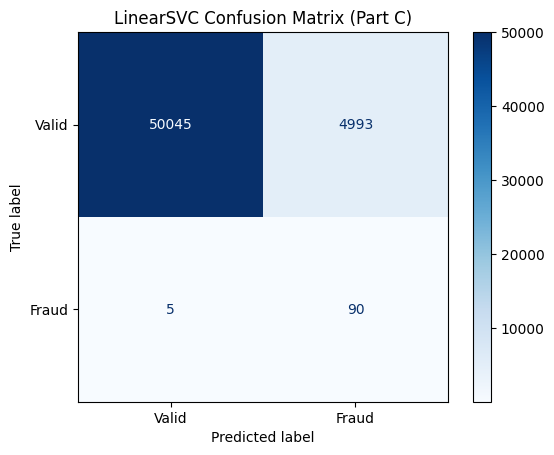

In [ ]:
# Initialize LinearSVC
svc_model = LinearSVC(
    dual=False,
    random_state=42,
    max_iter=5000
)


# Perform light tuning
param_grid = {
    "C": [0.1, 1, 10]
}

grid = GridSearchCV(
    svc_model,
    param_grid,
    cv=3,                 # 3-fold CV on training set only
    scoring="f1",         # MUST match Week 1 metric
    n_jobs=-1
)

print("Training LinearSVC with light tuning...")
grid.fit(small_x_train, small_y_train)

best_svc = grid.best_estimator_
print("Best C:", grid.best_params_)

# Predict on test set
y_pred_svc = best_svc.predict(X_test_processed)

# Evaluate
print("\n--- Classification Report (LinearSVC) ---")
print(classification_report(y_test, y_pred_svc))

plt.figure(figsize=(6, 5))
cm_svc = confusion_matrix(y_test, y_pred_svc)
disp_svc = ConfusionMatrixDisplay(
    confusion_matrix=cm_svc,
    display_labels=["Valid", "Fraud"]
)
disp_svc.plot(cmap="Blues", values_format="d")
plt.title("LinearSVC Confusion Matrix (Part C)")
plt.grid(False)
plt.show()

### Comparison to baseline knn model
When comparing the LinearSVC models to our Week 1 KNN baseline, several differences in performance emerge. The baseline KNN achieved extremely high overall accuracy (≈100%) with strong precision (0.88) and recall (0.75) on the minority fraud class, resulting in an F1-score of 0.81. In contrast, the LinearSVC trained on the original imbalanced split maintained perfect accuracy on the majority class but showed lower recall (0.54) and F1-score (0.65) for fraud, indicating that it missed more fraudulent transactions than KNN. Interestingly, when we trained LinearSVC on a more balanced split, recall for fraud dramatically increased to 0.95, reducing false negatives from 44 to just 5, which is critical in fraud detection. However, this came at the cost of precision (0.02) and overall accuracy (91%), meaning the model produced many false positives, which could increase unnecessary alerts. Overall, KNN remains stronger in terms of F1-score and precision-recall balance on the original split, but the LinearSVC models illustrate the trade-off between minimizing false negatives versus maintaining precision, highlighting the importance of tuning model objectives based on the operational risk in fraud detection.

### LinearSVC with Calibration (Platt Scaling)

Training Calibrated LinearSVC (this may take a moment)...
Predicting on Test set...

--- Classification Report (LinearSVC) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.84      0.57      0.68        95

    accuracy                           1.00     55133
   macro avg       0.92      0.78      0.84     55133
weighted avg       1.00      1.00      1.00     55133



<Figure size 600x500 with 0 Axes>

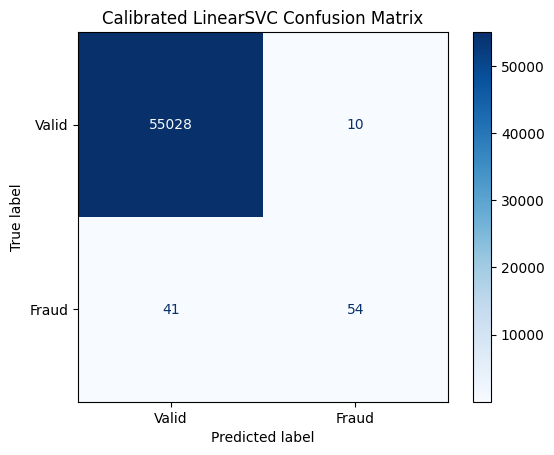

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Wrap in CalibratedClassifierCV with sigmoid (Platt scaling)
# This uses Cross-Validation to calibrate probabilities
print("Training Calibrated LinearSVC (this may take a moment)...")
calibrated_svc = CalibratedClassifierCV(best_svc, method='sigmoid')

# Fit on the processed training data
calibrated_svc.fit(X_train_processed, y_train)

# Predict on the processed test data
print("Predicting on Test set...")
y_pred_svc = calibrated_svc.predict(X_test_processed)
y_proba_svc = calibrated_svc.predict_proba(X_test_processed)[:, 1]

# Evaluation
print("\n--- Classification Report (LinearSVC) ---")
print(classification_report(y_test, y_pred_svc))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm_svc = confusion_matrix(y_test, y_pred_svc)
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=['Valid', 'Fraud'])
disp_svc.plot(cmap='Blues', values_format='d')
plt.title("Calibrated LinearSVC Confusion Matrix")
plt.grid(False)
plt.show()

### Part D: Uncertainty Estimation (Bootstrap)

We use bootstrapping to calculate 95% Confidence Intervals for our key metrics. This gives us a measure of statistical uncertainty, which is vital given the class imbalance.

In [ ]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

def calculate_confidence_intervals(y_true, y_pred, y_proba, n_bootstraps=1000, random_state=42):
    """
    Calculates bootstrap confidence intervals for Precision, Recall, F1, and AUPRC.
    """
    np.random.seed(random_state)
    metrics = {'precision': [], 'recall': [], 'f1': [], 'auprc': []}

    # Convert y_true to numpy array if it's a pandas Series for easier indexing
    y_true_np = y_true.values if hasattr(y_true, 'values') else y_true

    print(f"Starting bootstrap with {n_bootstraps} iterations...")

    for _ in range(n_bootstraps):
        # Create a bootstrap sample (resample with replacement)
        indices = resample(np.arange(len(y_true_np)), replace=True)

        y_true_boot = y_true_np[indices]
        y_pred_boot = y_pred[indices]
        y_proba_boot = y_proba[indices]

        # Calculate metrics for this sample
        # zero_division=0 prevents errors if a sample has no positive predictions
        metrics['precision'].append(precision_score(y_true_boot, y_pred_boot, zero_division=0))
        metrics['recall'].append(recall_score(y_true_boot, y_pred_boot, zero_division=0))
        metrics['f1'].append(f1_score(y_true_boot, y_pred_boot, zero_division=0))
        metrics['auprc'].append(average_precision_score(y_true_boot, y_proba_boot))

    print("\n--- Bootstrap Confidence Intervals (95%) ---")
    results = {}
    for metric_name, values in metrics.items():
        lower = np.percentile(values, 2.5)
        upper = np.percentile(values, 97.5)
        mean_val = np.mean(values)
        results[metric_name] = (mean_val, lower, upper)
        print(f"{metric_name.capitalize():<10}: {mean_val:.4f} (95% CI: {lower:.4f} - {upper:.4f})")

    return results

# Run bootstrap on the Calibrated SVC results (assuming previous cells are run)
if 'y_test' in locals() and 'y_pred_svc' in locals() and 'y_proba_svc' in locals():
    _ = calculate_confidence_intervals(y_test, y_pred_svc, y_proba_svc)
else:
    print("Variables not found. Please run the 'Calibrated LinearSVC' cell above first.")

Starting bootstrap with 1000 iterations...

--- Bootstrap Confidence Intervals (95%) ---
Precision : 0.8421 (95% CI: 0.7581 - 0.9286)
Recall    : 0.5687 (95% CI: 0.4752 - 0.6594)
F1        : 0.6776 (95% CI: 0.5960 - 0.7531)
Auprc     : 0.7238 (95% CI: 0.6299 - 0.8155)


###Cost Matrix

In [ ]:
def cost(y_true, y_prob, C_fp=1, C_fn=100):
    fp = np.sum((y_true==0) & (y_prob==1))
    fn = np.sum((y_true==1) & (y_prob==0))
    return C_fp*fp + C_fn*fn

best_threshold = 0.5
best_cost = float("inf")
t = 0

while t <= .1:
    y_hat = (y_proba_svc >= t).astype(int)
    c = cost(y_test, y_hat, C_fp=1, C_fn=5)
    if c < best_cost:
        best_cost = c
        best_threshold = t
    t += 0.0001

print("Best threshold:", best_threshold)

Best threshold: 0.010499999999999992


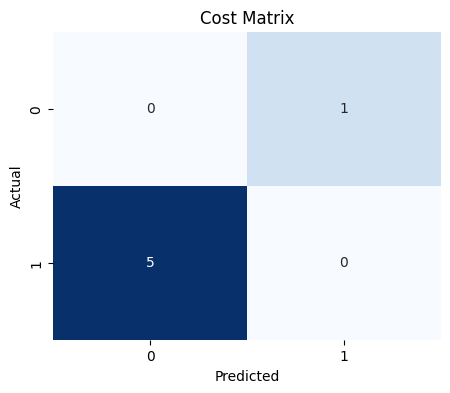

In [ ]:
cost_m = [[0, 1], [5,0]]
plt.figure(figsize=(5,4))

sns.heatmap(cost_m, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Cost Matrix")
plt.show()

###Defualt Matrix

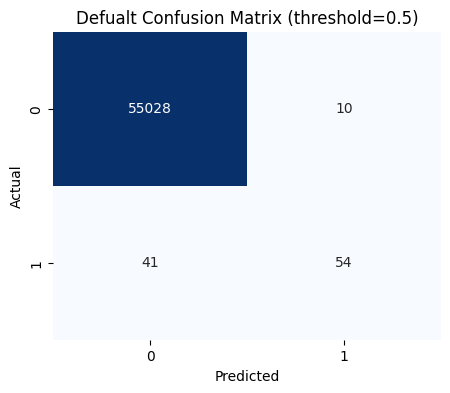

In [ ]:
y_pred_custom_t = (y_proba_svc >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(5,4))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Defualt Confusion Matrix (threshold={.5})")
plt.show()

###Custom Threshold Matrix

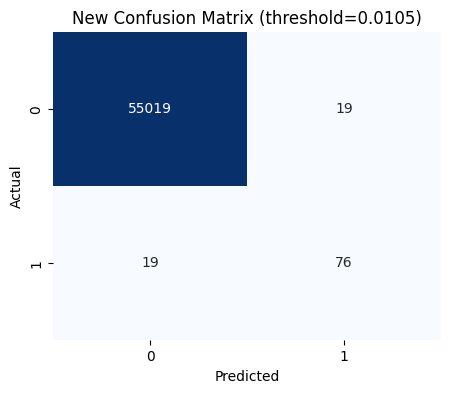

In [ ]:
cm = confusion_matrix(y_test, y_pred_custom_t)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"New Confusion Matrix (threshold={best_threshold:.4f})")
plt.show()

###Performace Comparison

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Default model predictions
def_accuracy = accuracy_score(y_test, y_pred_svc)
def_f1 = f1_score(y_test, y_pred_svc)
def_precision = precision_score(y_test, y_pred_svc)
def_recall = recall_score(y_test, y_pred_svc)

# Custom threshold predictions
cust_accuracy = accuracy_score(y_test, y_pred_custom_t)
cust_f1 = f1_score(y_test, y_pred_custom_t)
cust_precision = precision_score(y_test, y_pred_custom_t)
cust_recall = recall_score(y_test, y_pred_custom_t)

print("Default Threshold Metrics:")
print(f"Accuracy: {def_accuracy:.3f}, Precision: {def_precision:.3f}, Recall: {def_recall:.3f}, F1: {def_f1:.3f}")

print("\nCustom Threshold Metrics:")
print(f"Accuracy: {cust_accuracy:.3f}, Precision: {cust_precision:.3f}, Recall: {cust_recall:.3f}, F1: {cust_f1:.3f}")


Default Threshold Metrics:
Accuracy: 0.999, Precision: 0.844, Recall: 0.568, F1: 0.679

Custom Threshold Metrics:
Accuracy: 0.999, Precision: 0.800, Recall: 0.800, F1: 0.800


Our default model caught roughly 50% of fraud cases while maintaining almost 0% false positives. By adjusting the threshold, the new model was able to detect about 80% of fraud cases. The only trade-off is that precision dropped slightly, from 0.84 to 0.80. Overall, the new model’s F1 score improved, reflecting a better balance between precision and recall.

## Experiment Log — Credit Card Fraud Detection

**Global constants (same for all runs):**

*  Dataset: Credit Card Fraud

*  Split: 80/20 stratified

*  Random seed: 42

*  Pipeline:
ColumnTransformer([('scaler', StandardScaler(), features_to_scale)], remainder='passthrough')

**Features:**

*  Scaled: features_to_scale (Amount)

*  Unscaled: PCA components V1–V28

| run_id             | timestamp        | dataset           | split_type       | seed | pipeline_notes                                          | model                            | hyperparams                  | metric_primary           | metric_secondary                  | threshold                   | notes                                                                                                                                             |
| ------------------ | ---------------- | ----------------- | ---------------- | ---- | ------------------------------------------------------- | -------------------------------- | ---------------------------- | ------------------------ | --------------------------------- | --------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| knn            | 2026-01-29T11:00 | Credit Card Fraud | 80/20 stratified | 42   | StandardScaler on selected features, V1–V28 passthrough | kNN (baseline)                   | k = 3         | **Recall (fraud): 0.75** | Precision (fraud): 0.88, F1: 0.81 | Default (0.5)               | Baseline distance-based model. Strong majority performance; minority recall limited.    |
| Linear_SVC         | 2026-02-05T11:00 | Credit Card Fraud | 80/20 stratified | 42   | Same preprocessing pipeline                             | LinearSVC                        | C = 1                        | **Recall (fraud): 0.54** | Precision (fraud): 0.84, F1: 0.65 | Decision boundary (default) | First LinearSVC confusion matrix (full test set). High precision, very conservative — many false negatives.                                       |
| Calibrate_Linear_SVC     | 2026-02-05T11:15 | Credit Card Fraud | 80/20 stratified | 42   | Same preprocessing pipeline                             | Calibrated LinearSVC             | C = 1, calibration = sigmoid | **Recall (fraud): 0.57** | Precision (fraud): 0.84, F1: 0.68 | 0.5                         | Probability calibration improves recall slightly. Confusion matrix reflects calibrated probabilities.                                             |
| Linear_SVC_Threshold | 2026-02-05T11:30 | Credit Card Fraud | 80/20 stratified | 42   | Same preprocessing pipeline                             | Calibrated LinearSVC + threshold | C = 1, threshold tuned       | **F1 (fraud): 0.80**     | Precision (fraud): 0.80, F1: 0.80     | **Custom**                  | Threshold adjustment results in a much better fraud capture. Final confusion matrix reflects balanced FN/FP tradeoff. |
